### Phase Polynomial Sythesis

In [1]:
from src import z3_sat_solve_free_output
from qiskit import QuantumCircuit

# Number of qubit
n_qubit = 5

# Number of terms (like 'IZZI')
k = 7

# Logical Quantum Circuit
file = "benchmark/MaxCut_Random/logical/"+"Random"+ str(n_qubit) +"_"+ str(k) +"_logical_circuit.qasm"
qc = QuantumCircuit.from_qasm_file(file)

# Extract phase polynomial representation from Logical Circuit
from src.util import extract_parity_from_circuit_custom
output_parity, terms, params = extract_parity_from_circuit_custom(qc)
input_parity = [[True if i == j else False for j in range(n_qubit)] for i in range(n_qubit)]

# Get an initial layout; it can be random or generate from other method like qiskit
import json
with open("benchmark/MaxCut_Random/layout_melbourne/" + "Random" + str(n_qubit) + "_" + str(k) + "_OLSQ_layout.txt", "r") as file:
    layout = [int(line.strip()) for line in file]  # or use str(line.strip()) if they're strings
with open("Coupling_maps/melbourne.json", "r") as f:
    coupling_map = json.load(f)
index_map = {num: i for i, num in enumerate(layout)}
logical_subsubcoupling_map = [[index_map[a], index_map[b]] for a, b in coupling_map if a in layout and b in layout] 

# Systhesis the circuit
systhesis_circuit,_ = z3_sat_solve_free_output(n_qubit, 
                                                logical_subsubcoupling_map, 
                                                terms, 
                                                input_parity, 
                                                output_parity, 
                                                params,
                                                cnot_or_depth='cnot', 
                                                max_k =  20,
                                                display = True)

Elapsed time: 0.000481 seconds
No solution found for 1
Elapsed time: 0.003557 seconds
No solution found for 2
Elapsed time: 0.005339 seconds
No solution found for 3
Elapsed time: 0.007829 seconds
No solution found for 4
Elapsed time: 0.009484 seconds
No solution found for 5
Elapsed time: 0.012117 seconds
No solution found for 6
Elapsed time: 0.014548 seconds
No solution found for 7
Elapsed time: 0.022013 seconds
No solution found for 8
Elapsed time: 0.034301 seconds
No solution found for 9
Elapsed time: 0.060526 seconds
No solution found for 10
Elapsed time: 0.117169 seconds
No solution found for 11
Elapsed time: 0.379150 seconds
No solution found for 12
Elapsed time: 0.989794 seconds
No solution found for 13
Elapsed time: 0.703837 seconds
solution found for 14


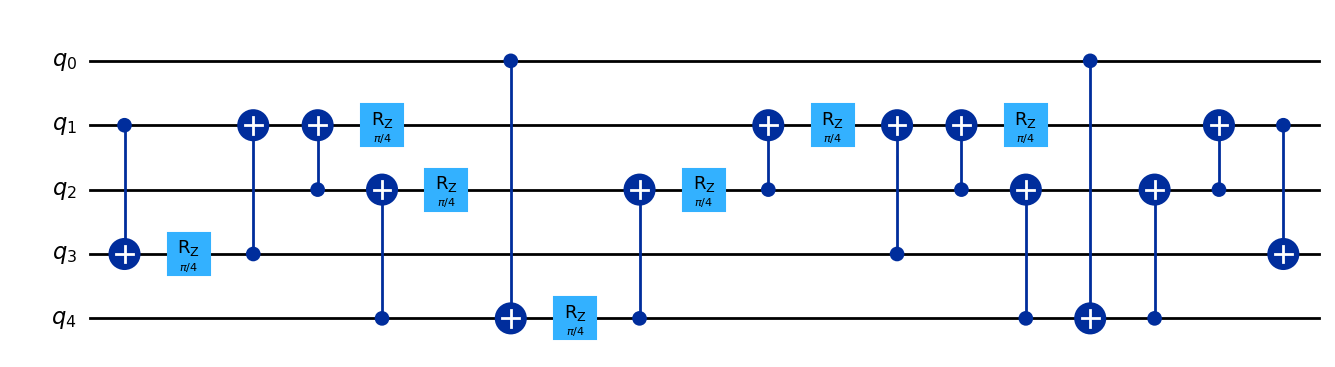

In [2]:
systhesis_circuit.draw()

### Optimization

In [9]:
import os
import json
from qiskit import QuantumCircuit

# Get hardware constrains (Note: is should be same size as circuit; allow to have ancilla qubit in the circuit)
with open("Coupling_maps/melbourne.json", "r") as f:
    coupling_map = json.load(f)

# Get a mapped circuit
path = 'benchmark/permuted_mapped/vbe_adder_3.qasm'
qc = QuantumCircuit.from_qasm_file(path)

# Use sat optimization
from src import block_opt_general, block_opt_qaoa, free_block_opt
opt_qc = block_opt_general(qc, 
                           coupling_map, 
                           cnot_or_depth='depth', # two options: cnot optimal or depth optimal
                           block_size=8, # max number of qubit for each block
                           max_depth=15,
                           method = 'phasepoly',
                           display = True) # 'phasepoly' or 'cnot'


Elapsed time: 0.000522 seconds
No solution found for 1
Elapsed time: 0.003140 seconds
No solution found for 2
Elapsed time: 0.003982 seconds
No solution found for 3
Elapsed time: 0.004854 seconds
No solution found for 4
Elapsed time: 0.006451 seconds
No solution found for 5
Elapsed time: 0.011774 seconds
No solution found for 6
Elapsed time: 0.020718 seconds
No solution found for 7
Elapsed time: 0.035416 seconds
No solution found for 8
Elapsed time: 0.033157 seconds
solution found for 9current cnot: 9
Try 9 cnots, success
Try 8 cnots, fail
Layer 0: [0] 0
Elapsed time: 0.000956 seconds
No solution found for 1
Elapsed time: 0.007813 seconds
No solution found for 2
Elapsed time: 0.012360 seconds
No solution found for 3
Elapsed time: 0.018821 seconds
No solution found for 4
Elapsed time: 0.053267 seconds
No solution found for 5
Elapsed time: 0.061924 seconds
No solution found for 6
Elapsed time: 0.177184 seconds
No solution found for 7
Elapsed time: 0.422436 seconds
No solution found for 8

In [3]:
!pip install pylatexenc

  Using cached pylatexenc-2.10-py3-none-any.whl


In [4]:
!pip install matplotlib

  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.5 MB/s eta 0:00:0000:01
Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 28.9 MB/s eta 0:00:00
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.7 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [matplotlib]8 [matplotlib]


In [3]:
!pip list

Package             Version
------------------- -----------
appnope             0.1.4
asttokens           3.0.0
bqskit              1.2.0
bqskitrs            0.4.1
comm                0.2.2
contourpy           1.3.0
cycler              0.12.1
debugpy             1.8.14
decorator           5.2.1
dill                0.4.0
exceptiongroup      1.2.2
executing           2.2.0
fonttools           4.57.0
importlib_metadata  8.6.1
importlib_resources 6.5.2
ipykernel           6.29.5
ipython             8.18.1
jedi                0.19.2
jupyter_client      8.6.3
jupyter_core        5.7.2
kiwisolver          1.4.7
lark                1.2.2
matplotlib          3.9.4
matplotlib-inline   0.1.7
mpmath              1.3.0
nest-asyncio        1.6.0
networkx            3.2.1
numpy               2.0.2
packaging           25.0
pandas              2.2.3
parso               0.8.4
pbr                 6.1.1
pexpect             4.9.0
pillow              11.2.1
pip                 25.1
platformdirs        4.3.7